In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import json
from sklearn.metrics import accuracy_score


In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/swaroop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/swaroop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/swaroop/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Preprocessing setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [4]:
# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  
    tokens = word_tokenize(text)  
    tokens = [word.lower() for word in tokens if word.isalpha()]  
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  
    return ' '.join(tokens)


In [5]:
# Load JSON lines file for testing
with open("test_seen.jsonl", "r") as f:
    test_json_lines = f.readlines()

In [6]:
# Parse JSON lines for testing
test_data = []
for line in test_json_lines:
    item = json.loads(line)
    test_data.append(item['text'])

In [7]:
# Load JSON lines file
with open("train.jsonl", "r") as f:
    train_json_lines = f.readlines()


In [8]:
# Parse JSON lines for training
train_data = []
for line in train_json_lines:
    item = json.loads(line)
    train_data.append((item['text'], item['label']))

# Convert training data to DataFrame
train_df = pd.DataFrame(train_data, columns=['text', 'label'])

# Apply preprocessing to training data
train_df['clean_text'] = train_df['text'].apply(preprocess_text)



In [9]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(train_df['clean_text'])
y_train = train_df['label']

In [10]:
classifier = LinearSVC()
classifier.fit(X_train_vec, y_train)


/home/swaroop/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
# Get the feature names from the TfidfVectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients (weights) from the trained LinearSVC model
coefficients = classifier.coef_[0]

# Create a dictionary with feature names as keys and coefficients as values
word_coef = dict(zip(feature_names, coefficients))

# Separate words with positive coefficients (indicating association with hateful class)
hateful_words = {word: coef for word, coef in word_coef.items() if coef > 0}

# Separate words with negative coefficients (indicating association with non-hateful class)
non_hateful_words = {word: coef for word, coef in word_coef.items() if coef < 0}

# Generate word clouds for hateful and non-hateful words
hateful_cloud = WordCloud(width=140, height=140, background_color ='white').generate_from_frequencies(hateful_words)
non_hateful_cloud = WordCloud(width=140, height=140, background_color ='white').generate_from_frequencies(non_hateful_words)



In [13]:
print(feature_names)

['abandon' 'abdul' 'abiding' ... 'zoo' 'zoroastrain' 'zuckerberg']


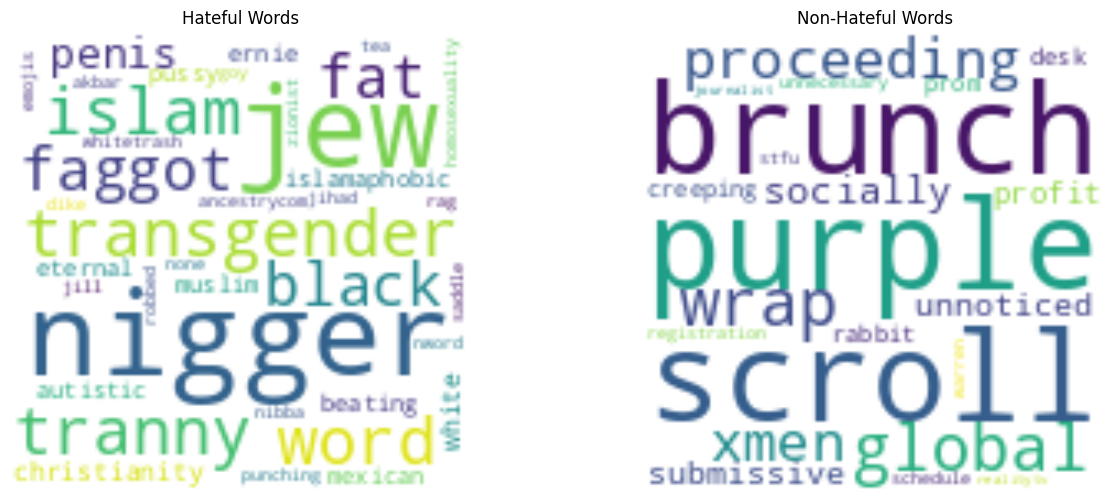

In [14]:
# Plot the word clouds
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(hateful_cloud, interpolation='bilinear')
plt.title('Hateful Words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_hateful_cloud, interpolation='bilinear')
plt.title('Non-Hateful Words')
plt.axis('off')

plt.show()

In [18]:
def classify_text(input_text):
    # Preprocess the input text
    preprocessed_text = preprocess_text(input_text)
    
    # Vectorize the preprocessed text
    text_vector = vectorizer.transform([preprocessed_text])
    
    # Predict the label using the trained classifier
    predicted_label = classifier.predict(text_vector)
    
    # Map the predicted label to its corresponding category
    if predicted_label[0] == 1:
        return "Hateful"
    else:
        return "Non-Hateful"

# Example usage:
input_text = "we talked about it  i agreed dinner would be ready on time in the future"
classification = classify_text(input_text)
print("Classification:", classification)


Classification: Non-Hateful


In [15]:
# Load JSON lines file for testing
with open("test_seen.jsonl", "r") as f:
    test_json_lines = f.readlines()

# Parse JSON lines for testing
test_data = []
for line in test_json_lines:
    item = json.loads(line)
    test_data.append((item['text'], item['id']))

# Predict labels for test data and save results to an external file
output_file = "text_predictions.txt"  # Define the output file name

with open(output_file, "w") as f:
    for text, image_id in test_data:
        prediction = classify_text(text)
        f.write(f"Text: {text} | Image ID: {image_id} | Prediction: {prediction}\n")

print(f"Predictions saved to {output_file}")


Predictions saved to text_predictions.txt


In [21]:
def calculate_toxicity_score(input_text):
    # Preprocess the input text
    preprocessed_text = preprocess_text(input_text)
    
    # Tokenize the preprocessed text
    tokens = word_tokenize(preprocessed_text)
    
    # Count the number of hateful words
    hateful_word_count = sum(classifier.predict(vectorizer.transform([word])) == 1 for word in tokens)
    
    # Calculate toxicity score
    total_words = len(tokens)
    toxicity_score = (hateful_word_count / total_words) * 100
    
    return toxicity_score

# Example usage:
input_text = "muslim"
toxicity_score = calculate_toxicity_score(input_text)
print("Toxicity Score:", toxicity_score)


Toxicity Score: [100.]


In [17]:
# Load JSON lines file for testing labels
with open("test_seen.jsonl", "r") as f:
    test_labels_json_lines = f.readlines()

In [18]:

# Parse JSON lines for testing
test_data = []
test_labels = []
for line in test_json_lines:
    item = json.loads(line)
    test_data.append(item['text'])
    test_labels.append(item['label'])

In [19]:
# Preprocess the testing data
test_data_preprocessed = [preprocess_text(text) for text in test_data]


In [20]:
# Vectorize the preprocessed testing data
X_test_vec = vectorizer.transform(test_data_preprocessed)

# Predict labels for the testing data
predictions = classifier.predict(X_test_vec)

In [23]:
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)


1 0
Accuracy: 0.562
